In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
%matplotlib ipympl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

2025-07-12 07:35:24.885303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752305725.106689      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752305725.170954      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!pip install -q albumentations

In [4]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU setup completed.")
    except RuntimeError as e:
        print(f"RuntimeError: {e}")
else:
    print("No GPU devices found.")

GPU setup completed.


In [5]:
folder_path = '/kaggle/input/aptos2019-blindness-detection/train_images'

In [6]:
train_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')

train_df['id_code'] = train_df['id_code'] + '.png'
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [7]:
print(train_df.shape)
print(test_df.shape)

(3662, 2)
(1928, 1)


In [8]:
train_df_shuffled = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
final_train_df, test_df = train_test_split(train_df_shuffled, test_size=0.2, stratify=train_df_shuffled['diagnosis'], random_state=42)
final_val_df, final_test_df = train_test_split(test_df, test_size=0.2, stratify=test_df['diagnosis'], random_state=42)

## Class Weights

In [10]:
from sklearn.utils.class_weight import compute_class_weight

train_df['diagnosis'] = train_df['diagnosis'].astype(int)

# Compute class weights
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_df['diagnosis']),
    y = train_df['diagnosis']
)
class_weights = dict(enumerate(class_weights))

## Preprocessing

In [11]:
import cv2
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import concurrent.futures
from scipy.signal import find_peaks
from skimage.filters import frangi
from skimage import img_as_float

IMG_SIZE = 384  # Resize size
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # CLAHE config

# Smooth histogram
def smooth_histogram(x, window_len=11, window='hanning'):
    if x.ndim != 1 or x.size < window_len:
        raise ValueError
    if window_len < 3:
        return x
    if window not in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError

    s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    w = np.ones(window_len, 'd') if window == 'flat' else eval('np.' + window + '(window_len)')
    return np.convolve(w / w.sum(), s, mode='valid')

# Crop function to remove black border
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    return img[np.ix_(mask.any(1), mask.any(0))] if mask.any() else img

def enhance_and_merge(image):
    # Extract green channel
    green = image[:, :, 1]
    
    # Apply CLAHE to green channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(green)
    image_g = enhanced.copy()
    
    # Histogram
    hist = cv2.calcHist([image_g], [0], None, [256], [0, 256])
    
    # Smooth Histogram
    hist_smooth = smo_hist = smooth_histogram(hist.ravel(), 5)
    
    # Find peaks
    peaks, _ = find_peaks(hist_smooth, distance=10)
    threshold = np.std(image_g[peaks])
    
    # Mask
    binary_roi = (image_g > threshold)
    
    # Convert back to binary Image
    binary_roi = binary_roi.astype("uint8")

    # subtract backgroud
    sub = enhanced * binary_roi

    # Step 3: Normalize and convert to float
    enhanced_float = img_as_float(enhanced)

    # Step 4: Apply Frangi vesselness filter
    frangi_output = frangi(enhanced_float)

    # Step 5: Thresholding
    vessel_thresh = (frangi_output > 0.1).astype(np.uint8)  # You can adjust this threshold

    # Step 6: Morphological closing to connect broken vessels
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    closed = cv2.morphologyEx(vessel_thresh, cv2.MORPH_CLOSE, kernel)

    # Merge ROI + vessels
    merged = cv2.add(closed, sub)

    # Convert all to 3-channel
    merged_rgb = cv2.merge([merged, merged, merged])
    return merged_rgb

def process_image(row, input_dir, output_dir):
    image_name = row['id_code']
    image_path = os.path.join(input_dir, image_name)
    output_path = os.path.join(output_dir, image_name)

    if not os.path.exists(image_path):
        return

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_cropped = crop_image_from_gray(image)
    image_resized = cv2.resize(image_cropped, (IMG_SIZE, IMG_SIZE))

    # Enhance + ROI + Merge vessels
    processed = enhance_and_merge(image_resized)

    # Save final result
    os.makedirs(output_dir, exist_ok=True)
    final_bgr = cv2.cvtColor(processed, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, final_bgr)

In [12]:
# Parallel execution
def process_images_parallel(df, input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        list(tqdm(executor.map(
            lambda row: process_image(row, input_dir, output_dir),
            [row for _, row in df.iterrows()]
        ), total=df.shape[0], desc=f"Processing images in {output_dir}", unit="image"))

In [13]:
# Set these as per your environment
processed_train_folder = '/kaggle/output/processed_train_images'
processed_val_folder = '/kaggle/output/processed_val_images'
processed_test_folder = '/kaggle/output/processed_test_images'

process_images_parallel(final_train_df, folder_path, processed_train_folder)
process_images_parallel(final_val_df, folder_path, processed_val_folder)
process_images_parallel(final_test_df, folder_path, processed_test_folder)

Processing images in /kaggle/output/processed_train_images: 100%|██████████| 2929/2929 [15:40<00:00,  3.11image/s]
Processing images in /kaggle/output/processed_val_images: 100%|██████████| 586/586 [03:08<00:00,  3.10image/s]
Processing images in /kaggle/output/processed_test_images: 100%|██████████| 147/147 [00:48<00:00,  3.01image/s]


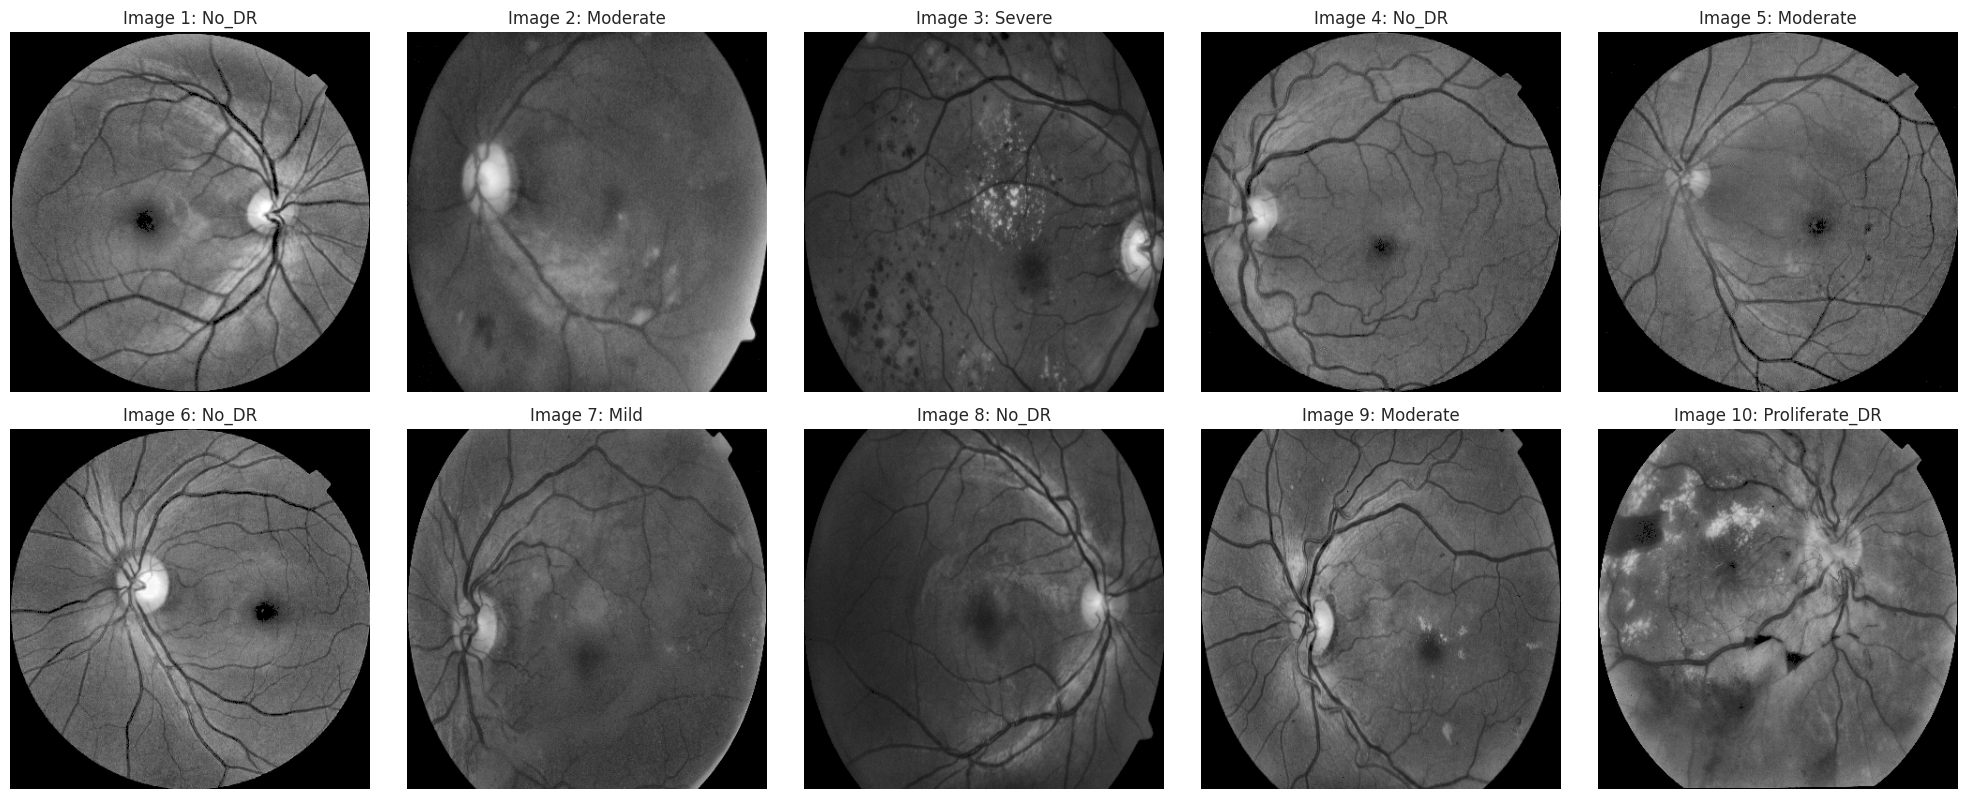

In [14]:
%matplotlib inline

level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Plotting
sns.set_style("white")
plt.figure(figsize=[20, 20])
count = 1

for img_name in final_train_df['id_code'][:10]:  # Show first 10
    img_path = os.path.join(processed_train_folder, img_name)
    img = cv2.imread(img_path)[..., [2, 1, 0]]  # Convert BGR to RGB for display
    label = int(final_train_df[final_train_df['id_code'] == img_name]['diagnosis'].values[0])

    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")
    plt.axis('off')
    count += 1

plt.tight_layout()
plt.show()

## Data Augmentation

In [15]:
train_datagen = ImageDataGenerator(rescale = 1 / 255.,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = [0.8, 1.2],
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1 / 255.)
test_datagen = ImageDataGenerator(rescale = 1 / 255.)

In [16]:
train_generator = train_datagen.flow_from_dataframe(final_train_df,
                                                    directory = processed_train_folder,
                                                    x_col = 'id_code',
                                                    y_col = 'diagnosis',
                                                    target_size = (384, 384),
                                                    batch_size = 32,
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_dataframe(final_val_df,
                                                  directory = processed_val_folder,
                                                  x_col = 'id_code',
                                                  y_col = 'diagnosis',
                                                  target_size = (384, 384),
                                                  batch_size = 32,
                                                  class_mode = 'categorical')

test_generator = test_datagen.flow_from_dataframe(final_test_df,
                                                  directory = processed_test_folder,
                                                  x_col = 'id_code',
                                                  y_col = 'diagnosis',
                                                  target_size = (384, 384),
                                                  batch_size = 32,
                                                  class_mode = 'categorical')

Found 2929 validated image filenames belonging to 5 classes.
Found 586 validated image filenames belonging to 5 classes.
Found 147 validated image filenames belonging to 5 classes.


## Callbacks

In [17]:
def categorical_focal_loss(gamma = 2.0, alpha = 0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_factor = alpha * tf.pow(1 - y_pred, gamma)
        loss = focal_factor * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return loss_fn

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        logs['learning_rate'] = tf.keras.backend.get_value(lr)


lr_scheduler = ReduceLROnPlateau(
    monitor ='val_loss', factor = 0.5, patience = 4, verbose = 1, min_lr = 1e-6
)

early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True,
    verbose = 1
)

callback = [early_stop, lr_scheduler, LearningRateLogger()]

## Custom Model Making

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

class GeMPoolingLayer(layers.Layer):
    def __init__(self, p=3.0, eps=1e-6, trainable=True, **kwargs):
        super(GeMPoolingLayer, self).__init__(**kwargs)
        self.eps = eps
        self.init_p = p
        self.trainable = trainable

    def build(self, input_shape):
        self.p = self.add_weight(
            name='p', shape=(1,),
            initializer=tf.keras.initializers.Constant(self.init_p),
            trainable=self.trainable
        )
        super(GeMPoolingLayer, self).build(input_shape)

    def call(self, inputs):
        x = tf.clip_by_value(inputs, self.eps, tf.reduce_max(inputs))
        x = tf.pow(x, self.p)
        x = tf.reduce_mean(x, axis=[1, 2], keepdims=False)
        return tf.pow(x, 1.0 / self.p)

    def get_config(self):
        config = super(GeMPoolingLayer, self).get_config()
        config.update({'p': self.init_p, 'eps': self.eps, 'trainable': self.trainable})
        return config


In [20]:
def depthwise_separable_conv(inputs, filters, strides = 1, use_se = False):
    
    x = layers.DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size = 1, strides = 1, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    if use_se:
        x = squeeze_excitation_block(x)

    return x

In [21]:
def squeeze_excitation_block(inputs, ratio = 16):
    
    filters = inputs.shape[-1]
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(filters // ratio, activation = 'relu')(x)
    x = layers.Dense(filters, activation = 'sigmoid')(x)
    x = layers.Reshape((1, 1, filters))(x)
    return layers.Multiply()([inputs, x])


In [22]:
def build_model():
    inputs = layers.Input(shape=(384, 384, 3))

    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = depthwise_separable_conv(x, 64, strides=1, use_se=True)
    x = depthwise_separable_conv(x, 256, strides=2, use_se=True)
    x = depthwise_separable_conv(x, 256, strides=1, use_se=True)
    x = depthwise_separable_conv(x, 512, strides=2, use_se=True)
    x = depthwise_separable_conv(x, 256, strides=1, use_se=True)
    x = depthwise_separable_conv(x, 1024, strides=2, use_se=True)
    x = depthwise_separable_conv(x, 512, strides=1, use_se=True)

    # Global Average Pooling and Dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(5, activation = 'softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [23]:
model = build_model()

I0000 00:00:1752306924.849855      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


In [24]:
import time 
now = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch = 2000, # batch size
    epochs = 70,
    validation_data = validation_generator,
    validation_steps = 800, # batch size
    callbacks = callback
)

print(f"Total Training time: {(time.time() - now) / 3600: .4f}hrs")

Epoch 1/70


I0000 00:00:1752306949.775250     156 service.cc:148] XLA service 0x7ba6493a89e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752306949.776046     156 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752306951.891194     156 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1752306954.652387     156 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752306954.904289     156 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-12 07:55:58.453184: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,256,96,96]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,96,96]{3,2,1,0}, f32[256,256,1,1]{3,2,1,0}, f32

  31/2000 ━━━━━━━━━━━━━━━━━━━━ 39:51 1s/step - accuracy: 0.5001 - loss: 1.2808

E0000 00:00:1752307021.640793     156 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752307021.845137     156 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752307029.700511     156 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752307029.961576     156 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752307031.548591     156 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

  92/2000 ━━━━━━━━━━━━━━━━━━━━ 46:29 1s/step - accuracy: 0.5622 - loss: 1.1861

E0000 00:00:1752307122.852447     158 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752307123.029065     158 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 198s 73ms/step - accuracy: 0.6059 - loss: 1.1185 - val_accuracy: 0.2730 - val_loss: 1.6496 - learning_rate: 0.0010
Epoch 2/70
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 121s 60ms/step - accuracy: 0.6429 - loss: 1.0308 - val_accuracy: 0.2730 - val_loss: 1.9159 - learning_rate: 0.0010
Epoch 3/70
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 123s 61ms/step - accuracy: 0.6605 - loss: 0.9631 - val_accuracy: 0.2730 - val_loss: 2.3558 - learning_rate: 0.0010
Epoch 4/70
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 122s 60ms/step - accuracy: 0.6842 - loss: 0.8945 - val_accuracy: 0.2730 - val_loss: 2.1495 - learning_rate: 0.0010
Epoch 5/70
  92/2000 ━━━━━━━━━━━━━━━━━━━━ 40:06 1s/step - accuracy: 0.7075 - loss: 0.7933
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 121s 60ms/step - accuracy: 0.7094 - loss: 0.7864 - val_accuracy: 0.2730 - val_loss: 2.1620 - learning_rate: 5.0000e-04
Epoch 6/70
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 121s 60ms/step - accuracy

In [25]:
model.save('/kaggle/working/preprocessed_model.h5')

In [26]:
from IPython.display import FileLink
FileLink('/kaggle/working/preprocessed_model.h5')

/kaggle/working/preprocessed_model.h5

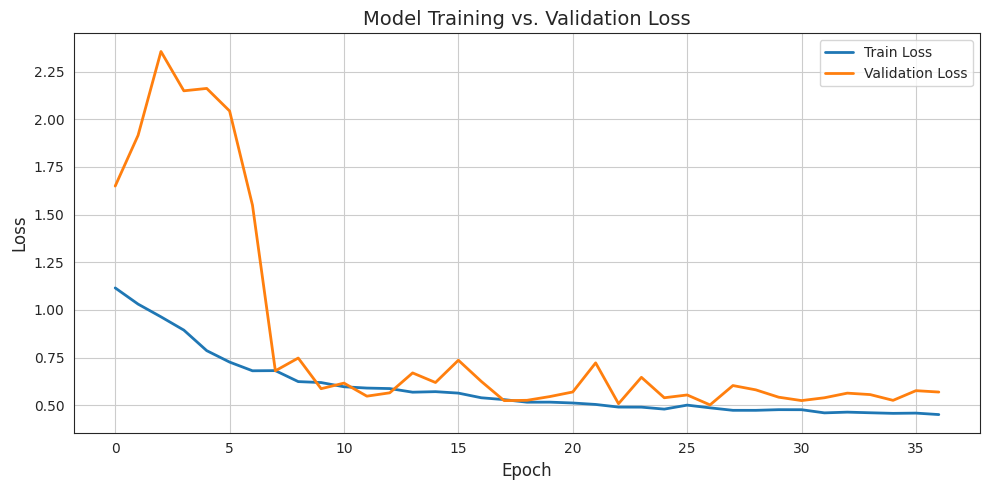

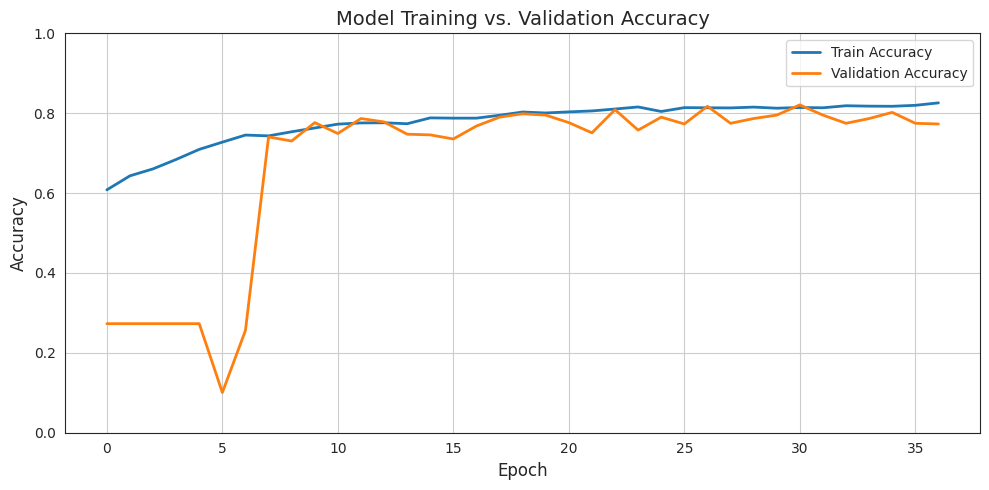

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot Loss (linear scale)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Training vs. Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Training vs. Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
def evaluate_model_from_generator(model, generator, loss_fn):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_images, batch_labels in generator:
        batch_size = batch_images.shape[0]

        predictions = model(batch_images, training=False)
        loss = tf.reduce_sum(loss_fn(batch_labels, predictions)).numpy()  # sum, not mean

        total_loss += loss

        # Accuracy: convert one-hot to class indices
        true_classes = np.argmax(batch_labels, axis=1)
        pred_classes = np.argmax(predictions, axis=1)
        correct = np.sum(true_classes == pred_classes)

        total_correct += correct
        total_samples += batch_size

        if total_samples >= generator.samples:
            break

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc

In [31]:
t = time.time()

loss_fn = tf.keras.losses.CategoricalCrossentropy()

train_loss, train_acc = evaluate_model_from_generator(model, train_generator, loss_fn)
print(f"Train Accuracy: {train_acc * 100:.2f}%")

val_loss, val_acc = evaluate_model_from_generator(model, validation_generator, loss_fn)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

test_loss, test_acc = evaluate_model_from_generator(model, test_generator, loss_fn)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

print(f"Total Evaluation time: {(time.time() - t) / 60: .2f} mins")

Train Accuracy: 82.28%
Validation Accuracy: 81.74%
Test Accuracy: 82.99%
Total Evaluation time:  2.33 mins


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['NO DR', 'MILD', 'MODERATE', 'SEVERE', 'PROLIFERATE']

y_true = []
y_pred = []

for batch_images, batch_labels in validation_generator:
    predictions = model(batch_images, training=False)  

    # If labels are one-hot encoded, convert to integer class labels
    if batch_labels.shape[-1] == len(class_names):  # one-hot
        true_classes = tf.argmax(batch_labels, axis=1)
    else:  # already integer labels
        true_classes = tf.cast(batch_labels, tf.int64)

    predicted_classes = tf.argmax(predictions, axis=1)

    # Add to overall list
    y_true.extend(true_classes.numpy())
    y_pred.extend(predicted_classes.numpy())

    # Optional: break after all samples if generator loops infinitely
    if len(y_true) >= validation_generator.samples:
        break

# Evaluate
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       NO DR       0.99      1.00      0.99       289
        MILD       0.57      0.63      0.60        59
    MODERATE       0.69      0.81      0.74       160
      SEVERE       0.46      0.19      0.27        31
 PROLIFERATE       0.67      0.38      0.49        47

    accuracy                           0.82       586
   macro avg       0.67      0.60      0.62       586
weighted avg       0.81      0.82      0.81       586



In [35]:
from sklearn.metrics import cohen_kappa_score

# Assuming y_true and y_pred contain integer labels
kappa_score = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

Cohen's Kappa Score: 0.7190


In [36]:
from sklearn.metrics import cohen_kappa_score

qwk_score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Quadratic Weighted Kappa (QWK): {qwk_score:.4f}")

Quadratic Weighted Kappa (QWK): 0.8702


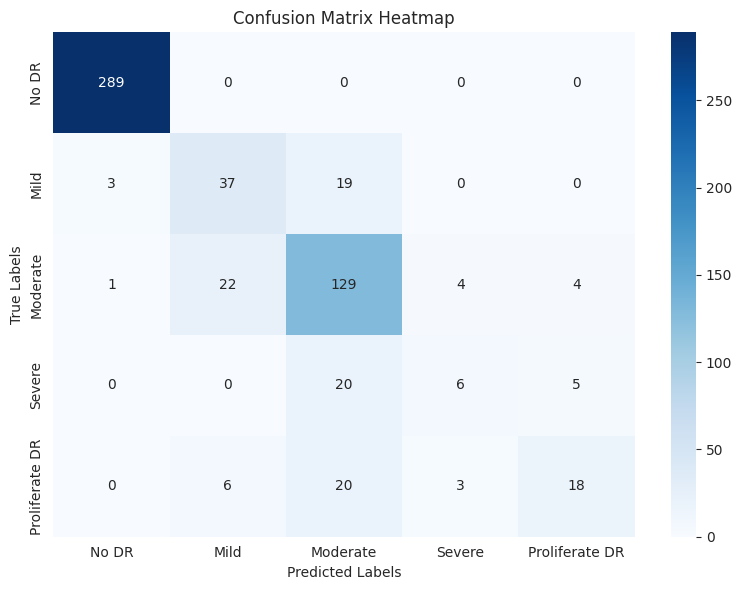

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferate DR"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

class_names = ['NO DR', 'MILD', 'MODERATE', 'SEVERE', 'PROLIFERATE']

y_true = []
y_pred = []

for batch_images, batch_labels in test_generator:
    predictions = model(batch_images, training=False)  

    # If labels are one-hot encoded, convert to integer class labels
    if batch_labels.shape[-1] == len(class_names):  # one-hot
        true_classes = tf.argmax(batch_labels, axis=1)
    else:  # already integer labels
        true_classes = tf.cast(batch_labels, tf.int64)

    predicted_classes = tf.argmax(predictions, axis=1)

    # Add to overall list
    y_true.extend(true_classes.numpy())
    y_pred.extend(predicted_classes.numpy())

    # Optional: break after all samples if generator loops infinitely
    if len(y_true) >= test_generator.samples:
        break

# Evaluate
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       NO DR       0.99      0.96      0.97        72
        MILD       0.71      0.67      0.69        15
    MODERATE       0.69      0.82      0.75        40
      SEVERE       0.60      0.38      0.46         8
 PROLIFERATE       0.70      0.58      0.64        12

    accuracy                           0.83       147
   macro avg       0.74      0.68      0.70       147
weighted avg       0.83      0.83      0.83       147



In [39]:
from sklearn.metrics import cohen_kappa_score

# Assuming y_true and y_pred contain integer labels
kappa_score = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

Cohen's Kappa Score: 0.7426


In [40]:
from sklearn.metrics import cohen_kappa_score

qwk_score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Quadratic Weighted Kappa (QWK): {qwk_score:.4f}")

Quadratic Weighted Kappa (QWK): 0.8737


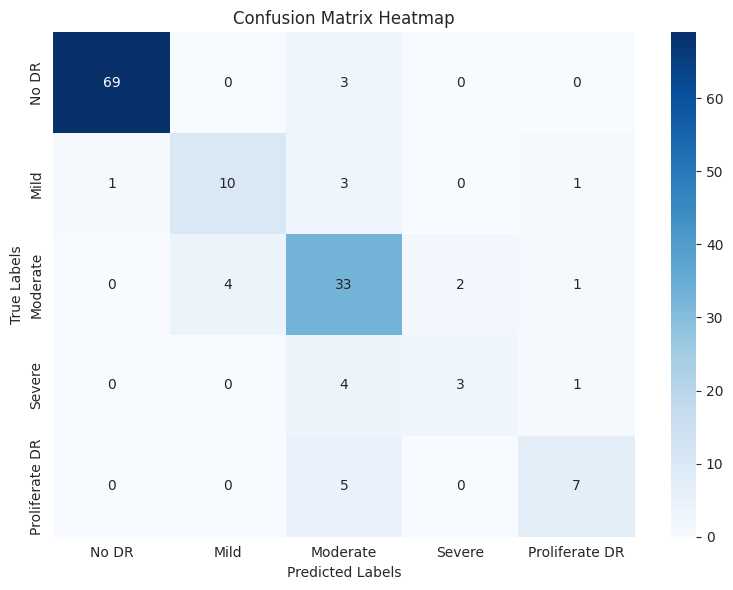

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferate DR"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

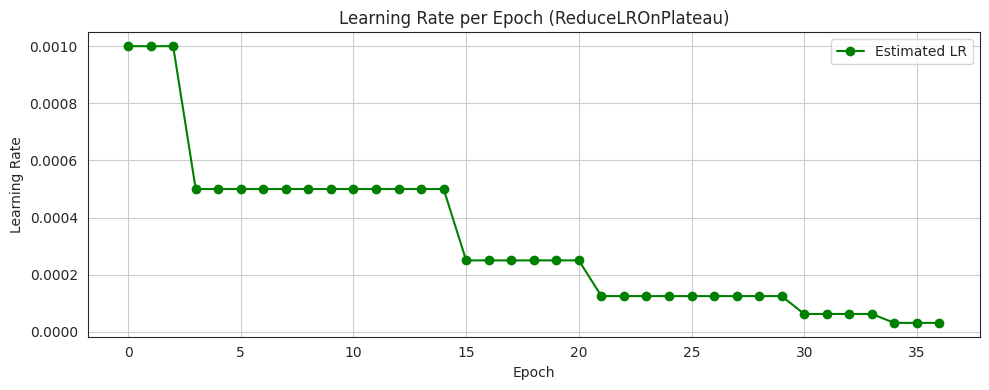

In [42]:
import matplotlib.pyplot as plt

initial_lr = 1e-3
factor = 0.5
patience = 4
min_lr = 1e-6
total_epochs = len(history.history['loss'])

lrs = []
lr = initial_lr
wait = 0

previous_loss = history.history['val_loss'][0]

for epoch in range(total_epochs):
    current_loss = history.history['val_loss'][epoch]
    
    if current_loss < previous_loss: 
        wait = 0
        previous_loss = current_loss
    else:
        wait += 1
        if wait >= patience:
            new_lr = max(lr * factor, min_lr)
            if new_lr < lr:
                lr = new_lr
            wait = 0

    lrs.append(lr)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(lrs, label='Estimated LR', color='green', marker='o')
plt.title('Learning Rate per Epoch (ReduceLROnPlateau)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

E0000 00:00:1752312273.885575     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752312274.032767     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752312274.165335     157 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


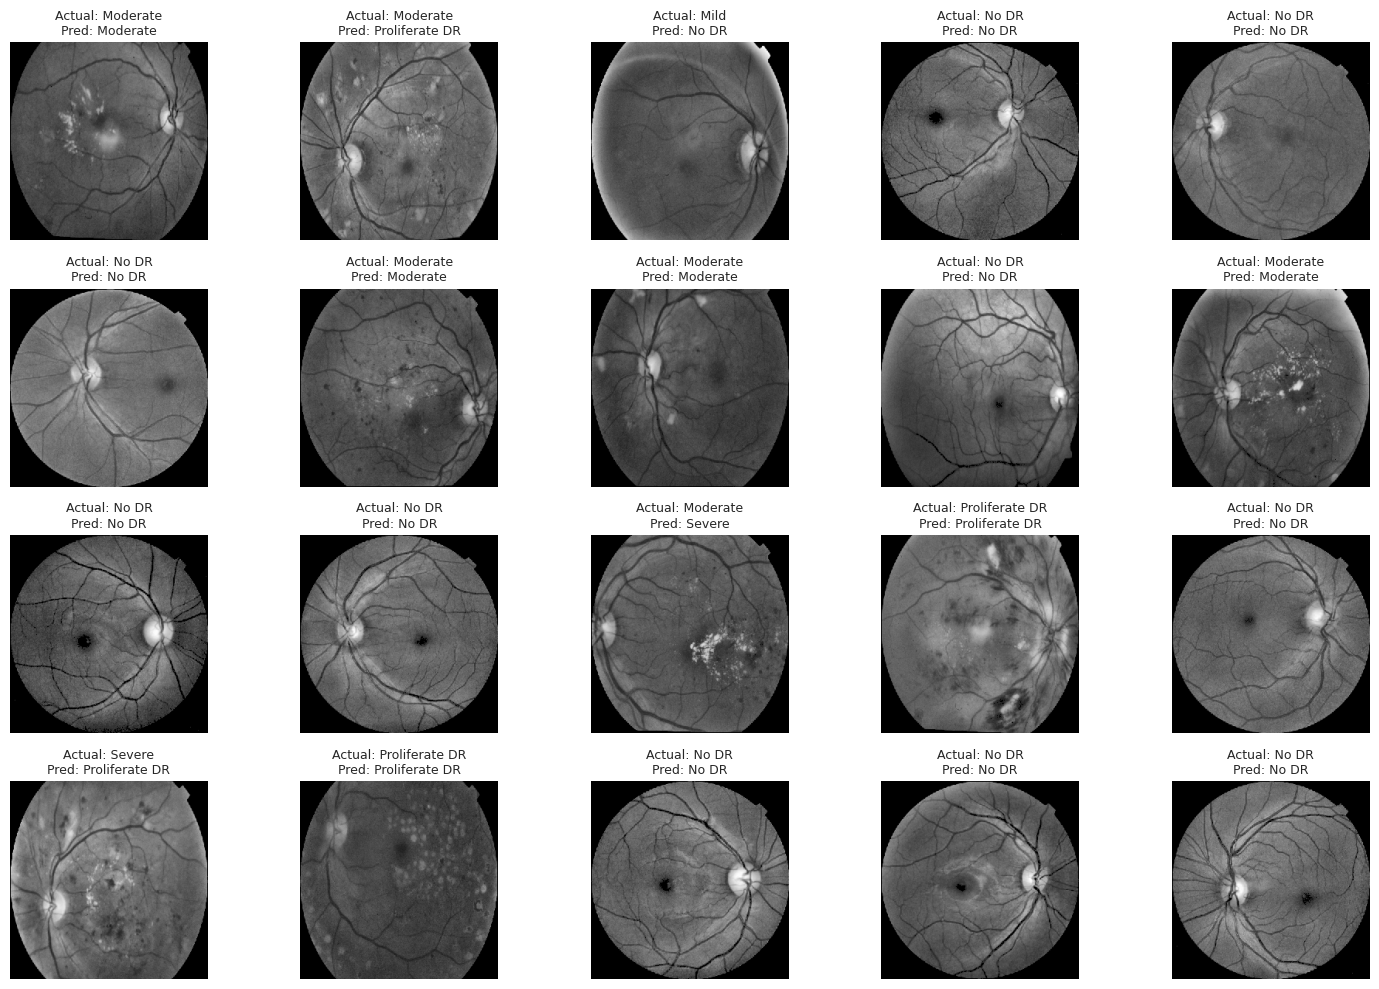

In [44]:
import matplotlib.pyplot as plt
import random
import numpy as np

label_mapping = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate DR"
}

plt.figure(figsize=(15, 10))

# Total samples
num_samples = len(test_generator.filenames)

indices = random.sample(range(num_samples), 20)

for i, idx in enumerate(indices):
    image_path = test_generator.filepaths[idx]
    image = tf.keras.utils.load_img(image_path, target_size=(256, 256))
    image_array = tf.keras.utils.img_to_array(image) / 255.0  # normalize
    image_input = np.expand_dims(image_array, axis=0)

    # Actual label
    actual_label = test_generator.classes[idx]

    # Prediction
    prediction = model.predict(image_input, verbose=0)
    pred_label = np.argmax(prediction)

    # Plotting
    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Actual: {label_mapping[actual_label]}\nPred: {label_mapping[pred_label]}", fontsize=9)

plt.tight_layout()
plt.show()

In [45]:
import pickle

# Save the history object
with open('preprocessd_model.pkl', 'wb') as f:
    pickle.dump(history.history, f)